In [34]:
import os
import numpy as np 
import pandas as pd 

from sklearn.model_selection import GroupShuffleSplit, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from typing import Any, Dict, Union
from yellowbrick import model_selection as ms
from yellowbrick.model_selection import validation_curve

from boruta import BorutaPy
from BorutaShap import BorutaShap
import matplotlib.pyplot as plt

### 1. Load dataframe with all features 

In [53]:
os.chdir('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Scripts/Preprocessing/')
%run constants.py

all_features = pd.read_csv('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Results/all_features.csv', index_col = 0)

### 2. Add genotype column

In [54]:
all_features['Genotype'] = np.where(all_features['Animal_ID'].isin(WT_ls), 0, 
                                    np.where(all_features['Animal_ID'].isin(GAP_ls), 1, -1))
columns = ['Genotype'] + [col for col in all_features.columns if col != 'Genotype']
all_features = all_features[columns]


In [55]:
print(len(WT_ls))
print(len(GAP_ls))

9
10


### 3. Separate into Train and Test set ensuring group split to prevent data leakage

In [56]:
X = all_features.iloc[:, 1:].drop(['Animal_ID'], axis = 1)
y = all_features.iloc[:, 0]
animal_ids = all_features['Animal_ID']

In [57]:
np.unique(y)

array([0, 1])

In [58]:
# Initial train-test split by group
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=animal_ids))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_ids = np.unique(animal_ids.iloc[train_idx])
test_ids = np.unique(animal_ids.iloc[test_idx])

In [60]:
X_train

,Epoch,Br_State,delta_power_chan_0,theta_power_chan_0,sigma_power_chan_0,beta_power_chan_0,gamma_power_chan_0,Intercept_chan_0,Slope_chan_0,delta_power_chan_2,...,15_4_gamma_plv,15_5_gamma_plv,15_6_gamma_plv,15_7_gamma_plv,15_8_gamma_plv,15_9_gamma_plv,15_10_gamma_plv,15_11_gamma_plv,15_12_gamma_plv,15_13_gamma_plv
0,0,0,123.658358,48.462083,20.684503,3.366798,1.291812,19.650605,-0.226963,114.522501,...,0.594191,0.630741,0.588289,0.666420,0.724461,0.852994,0.610261,0.726709,0.812664,0.648553
1,1,0,224.313298,70.259501,15.090559,3.200432,0.894935,30.511353,-0.355914,201.014243,...,0.574615,0.482699,0.442454,0.615069,0.648448,0.800886,0.549605,0.725397,0.754601,0.609599
2,3,0,17.558832,9.799747,15.930350,1.985093,0.604775,5.848222,-0.066379,31.157978,...,0.605086,0.540185,0.462324,0.660871,0.684047,0.814315,0.568078,0.756125,0.795766,0.665350
3,4,1,67.138310,24.435513,5.214817,2.396412,0.774870,11.154126,-0.129364,95.272055,...,0.618401,0.562490,0.495593,0.645870,0.665970,0.819192,0.566728,0.733562,0.800718,0.661162
4,5,1,131.140224,69.759832,16.050178,1.891239,0.725770,21.872405,-0.254306,131.901381,...,0.602866,0.566445,0.506357,0.658644,0.682147,0.822727,0.479459,0.733835,0.766606,0.639309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,17273,0,12.954653,7.559244,1.188368,1.392588,0.818882,4.867422,-0.054211,71.158950,...,0.643773,0.740882,0.362867,0.678806,0.852938,0.892244,0.907563,0.827010,0.837665,0.729459
10864,17274,0,10.045417,9.838700,0.987386,0.749845,0.524786,4.200723,-0.047039,101.471987,...,0.614733,0.702615,0.395295,0.648216,0.850052,0.900403,0.884055,0.761057,0.817609,0.675815
10865,17275,0,20.249282,7.280038,2.405264,1.084302,0.734814,3.337984,-0.035960,28.069987,...,0.665070,0.753837,0.434112,0.717732,0.870399,0.913543,0.903582,0.831821,0.858546,0.751967
10866,17276,0,18.940906,17.272793,2.500978,1.762027,0.718302,6.584401,-0.073646,61.581050,...,0.691688,0.763502,0.374632,0.746377,0.858915,0.901554,0.902199,0.818141,0.849133,0.734482


### 4. Feature Selection with BorutaSHAP

FOLD 1/3


  0%|          | 0/50 [00:00<?, ?it/s]

193 attributes confirmed important: ['9_6_gamma_plv', '12_0_sigma_plv', '7_2_beta_plv', '13_3_beta_plv', '10_7_gamma_plv', '13_3_theta_plv', '13_4_sigma_plv', '12_11_beta_plv', '13_4_beta_plv', '5_0_beta_plv', '6_5_theta_plv', '7_6_beta_plv', '7_6_gamma_plv', 'gamma_power_chan_9', '10_8_gamma_plv', '13_12_gamma_plv', 'gamma_power_chan_8', '12_10_sigma_plv', '10_9_gamma_plv', '12_6_beta_plv', '13_11_gamma_plv', 'beta_power_chan_8', '9_6_beta_plv', 'beta_power_chan_2', '6_5_beta_plv', 'gamma_power_chan_5', '15_9_beta_plv', '8_4_sigma_plv', '7_0_gamma_plv', '9_8_gamma_plv', '13_6_beta_plv', '6_3_beta_plv', '15_8_beta_plv', '10_3_gamma_plv', '5_2_sigma_plv', '10_5_gamma_plv', '12_3_beta_plv', '8_6_gamma_plv', '5_4_gamma_plv', '15_10_beta_plv', '3_0_theta_plv', '8_4_beta_plv', 'HFD_chan_0', '7_3_beta_plv', 'HFD_chan_2', '11_10_gamma_plv', '7_5_sigma_plv', 'theta_power_chan_4', '8_7_beta_plv', 'delta_power_chan_5', '7_4_gamma_plv', '11_8_gamma_plv', 'DispEn_8', '15_7_gamma_plv', '8_5_gamma_p

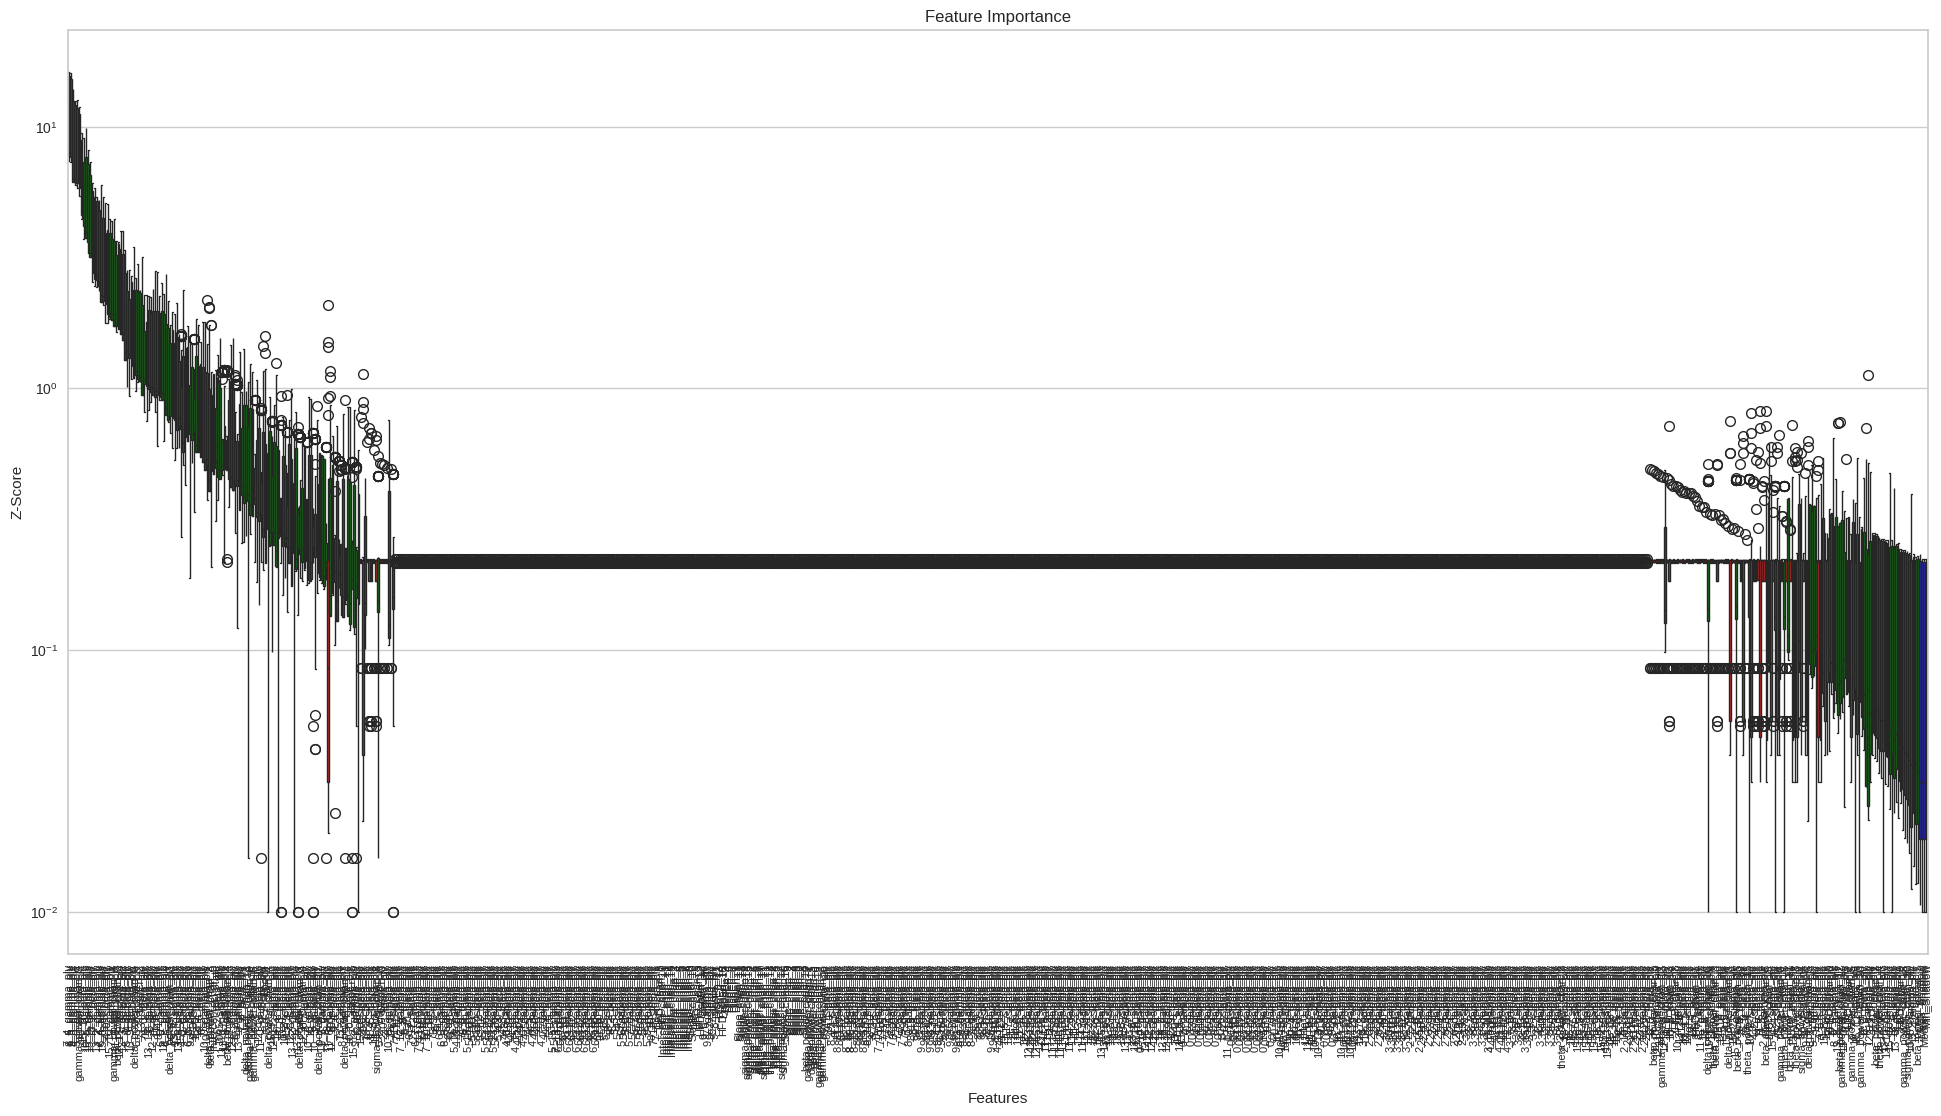

Selected features at fold 1 are: ['10_0_beta_plv', '10_0_gamma_plv', '10_0_sigma_plv', '10_0_theta_plv', '10_2_beta_plv', '10_3_gamma_plv', '10_5_beta_plv', '10_5_gamma_plv', '10_5_sigma_plv', '10_6_gamma_plv', '10_7_gamma_plv', '10_7_sigma_plv', '10_8_beta_plv', '10_8_gamma_plv', '10_8_sigma_plv', '10_9_beta_plv', '10_9_gamma_plv', '10_9_sigma_plv', '11_0_gamma_plv', '11_10_gamma_plv', '11_6_gamma_plv', '11_7_gamma_plv', '11_8_beta_plv', '11_8_gamma_plv', '11_9_gamma_plv', '12_0_sigma_plv', '12_10_sigma_plv', '12_11_beta_plv', '12_11_gamma_plv', '12_11_sigma_plv', '12_11_theta_plv', '12_2_beta_plv', '12_2_gamma_plv', '12_3_beta_plv', '12_3_gamma_plv', '12_4_beta_plv', '12_4_gamma_plv', '12_6_beta_plv', '12_7_gamma_plv', '12_8_beta_plv', '12_8_sigma_plv', '12_9_beta_plv', '13_0_gamma_plv', '13_10_gamma_plv', '13_11_gamma_plv', '13_11_sigma_plv', '13_12_beta_plv', '13_12_gamma_plv', '13_2_beta_plv', '13_2_gamma_plv', '13_2_theta_plv', '13_3_beta_plv', '13_3_gamma_plv', '13_3_theta_plv',

  0%|          | 0/50 [00:00<?, ?it/s]

179 attributes confirmed important: ['9_6_gamma_plv', '9_7_beta_plv', '13_3_beta_plv', '10_7_gamma_plv', '13_3_theta_plv', '13_4_sigma_plv', '12_11_beta_plv', '5_0_beta_plv', '11_2_beta_plv', '11_7_sigma_plv', '6_5_theta_plv', '7_6_beta_plv', '7_6_gamma_plv', 'gamma_power_chan_9', '10_8_gamma_plv', '9_0_sigma_plv', 'gamma_power_chan_8', '12_10_sigma_plv', '9_8_beta_plv', '10_9_gamma_plv', 'beta_power_chan_8', '11_2_gamma_plv', '9_6_beta_plv', '6_5_beta_plv', '15_9_beta_plv', '7_0_gamma_plv', 'beta_power_chan_2', '9_8_gamma_plv', '13_6_beta_plv', '4_3_theta_plv', '6_3_beta_plv', '15_8_beta_plv', '11_4_gamma_plv', 'HFD_chan_13', '10_3_beta_plv', '10_5_gamma_plv', '8_4_theta_plv', '5_4_gamma_plv', '15_10_beta_plv', '8_4_beta_plv', 'delta_power_chan_9', '12_10_gamma_plv', '7_3_beta_plv', '11_10_gamma_plv', '7_5_sigma_plv', '15_9_theta_plv', '8_7_beta_plv', '7_4_gamma_plv', '8_5_gamma_plv', 'gamma_power_chan_12', '7_4_beta_plv', '6_0_theta_plv', '3_2_gamma_plv', '12_11_theta_plv', '11_7_gam

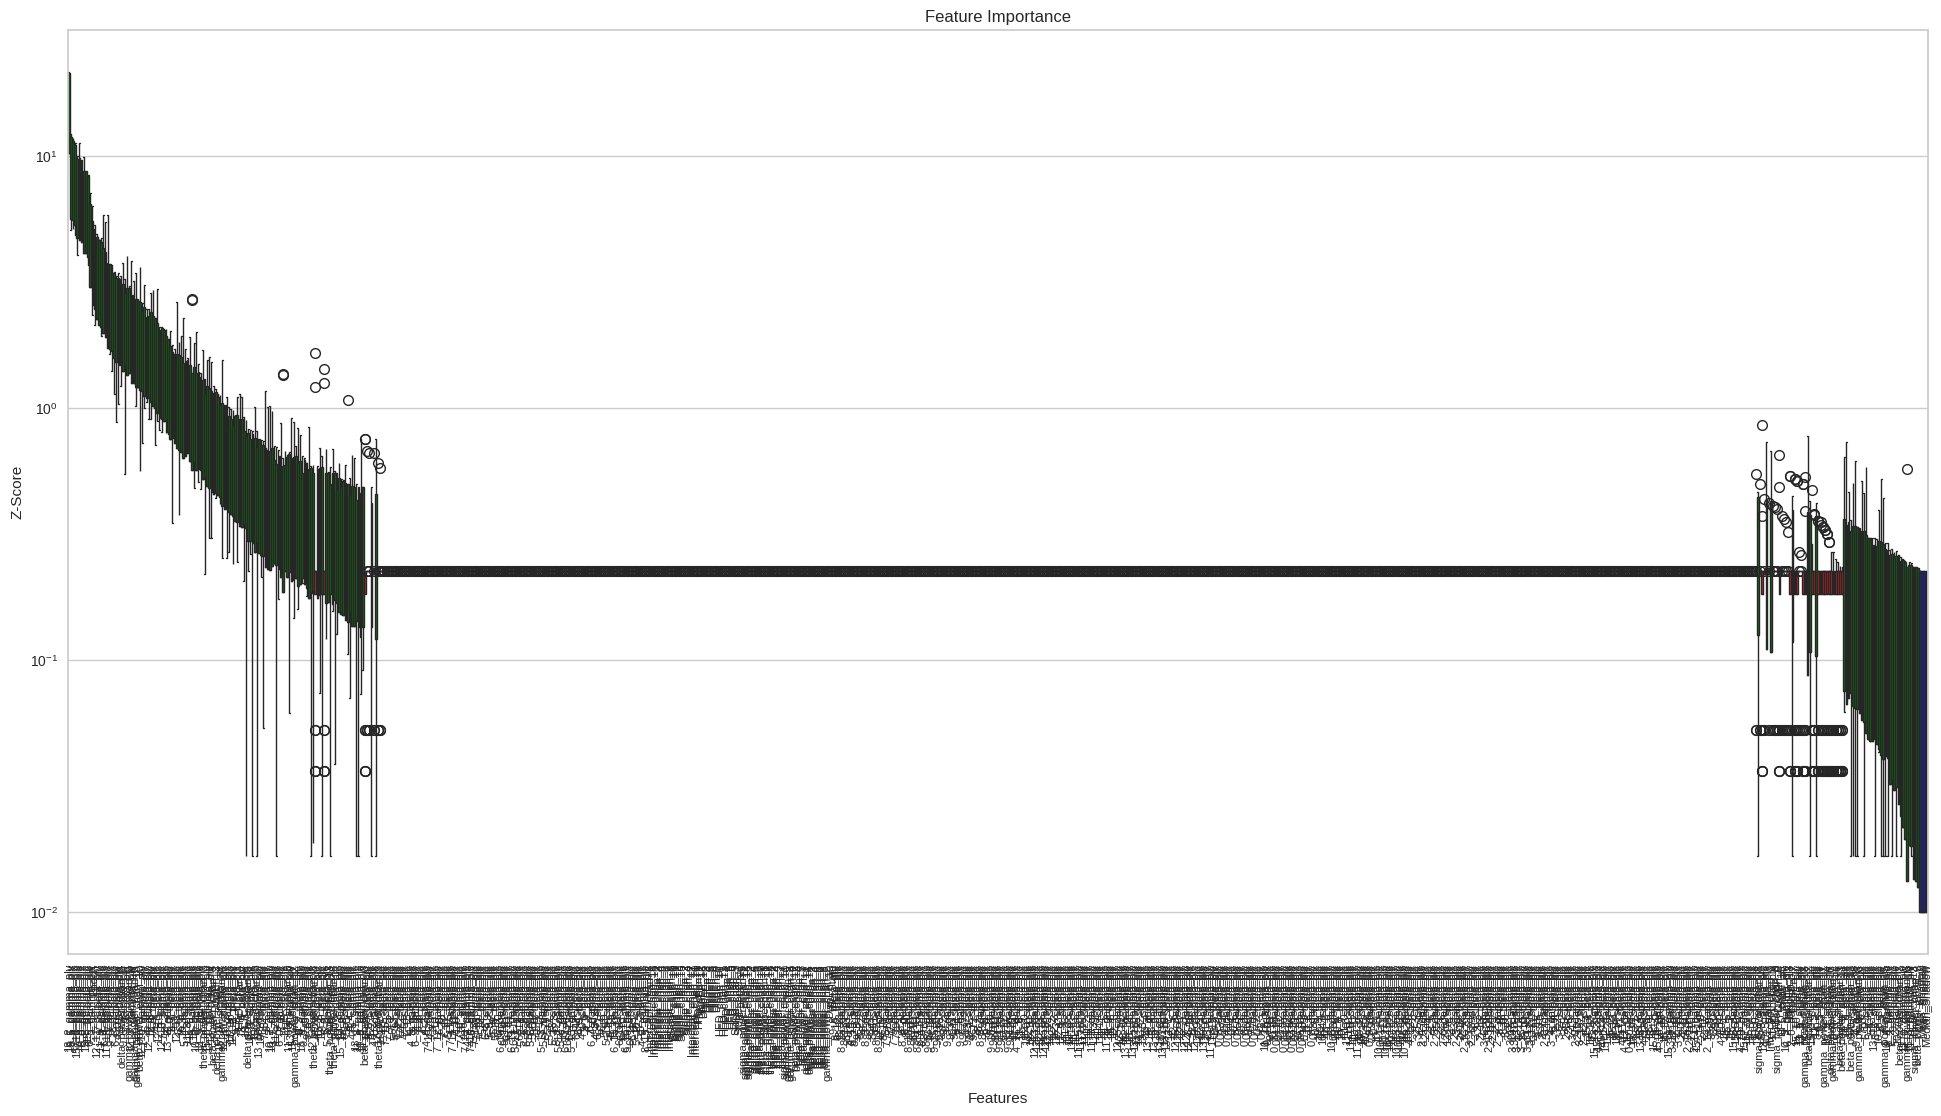

Selected features at fold 2 are: ['10_0_beta_plv', '10_0_gamma_plv', '10_0_sigma_plv', '10_2_beta_plv', '10_2_gamma_plv', '10_3_beta_plv', '10_3_sigma_plv', '10_4_gamma_plv', '10_5_gamma_plv', '10_5_sigma_plv', '10_5_theta_plv', '10_7_gamma_plv', '10_7_sigma_plv', '10_8_beta_plv', '10_8_gamma_plv', '10_8_sigma_plv', '10_8_theta_plv', '10_9_beta_plv', '10_9_gamma_plv', '11_0_gamma_plv', '11_10_beta_plv', '11_10_gamma_plv', '11_2_beta_plv', '11_2_gamma_plv', '11_4_gamma_plv', '11_6_gamma_plv', '11_7_beta_plv', '11_7_gamma_plv', '11_7_sigma_plv', '11_8_beta_plv', '11_8_gamma_plv', '11_8_sigma_plv', '11_9_gamma_plv', '12_0_gamma_plv', '12_10_beta_plv', '12_10_gamma_plv', '12_10_sigma_plv', '12_11_beta_plv', '12_11_gamma_plv', '12_11_sigma_plv', '12_11_theta_plv', '12_2_beta_plv', '12_2_gamma_plv', '12_3_gamma_plv', '12_4_beta_plv', '12_4_gamma_plv', '12_8_beta_plv', '13_10_gamma_plv', '13_11_beta_plv', '13_11_sigma_plv', '13_12_sigma_plv', '13_2_beta_plv', '13_2_gamma_plv', '13_3_beta_plv'

  0%|          | 0/50 [00:00<?, ?it/s]

117 attributes confirmed important: ['9_6_gamma_plv', '9_7_beta_plv', 'beta_power_chan_11', '13_3_beta_plv', '10_7_gamma_plv', '13_3_theta_plv', '13_4_sigma_plv', '12_11_beta_plv', '13_4_beta_plv', '5_0_beta_plv', '13_2_sigma_plv', '6_5_theta_plv', '12_6_sigma_plv', '13_12_gamma_plv', '10_9_gamma_plv', '12_10_sigma_plv', '7_4_sigma_plv', '11_2_gamma_plv', '9_6_beta_plv', '6_5_beta_plv', '7_0_gamma_plv', '11_4_gamma_plv', '10_3_gamma_plv', '10_5_gamma_plv', '12_3_beta_plv', '8_6_gamma_plv', '5_4_gamma_plv', '15_10_beta_plv', '12_10_gamma_plv', '7_3_beta_plv', '11_10_gamma_plv', '15_9_theta_plv', 'delta_power_chan_5', '7_4_gamma_plv', '8_5_gamma_plv', 'gamma_power_chan_12', '7_4_beta_plv', '12_11_theta_plv', '12_10_beta_plv', '10_5_sigma_plv', '15_10_gamma_plv', '13_8_gamma_plv', '4_0_gamma_plv', 'gamma_power_chan_15', 'beta_power_chan_0', '8_5_theta_plv', 'HFD_chan_4', '11_4_beta_plv', 'gamma_power_chan_7', '15_12_beta_plv', '13_3_gamma_plv', '11_3_gamma_plv', 'beta_power_chan_13', '4_2

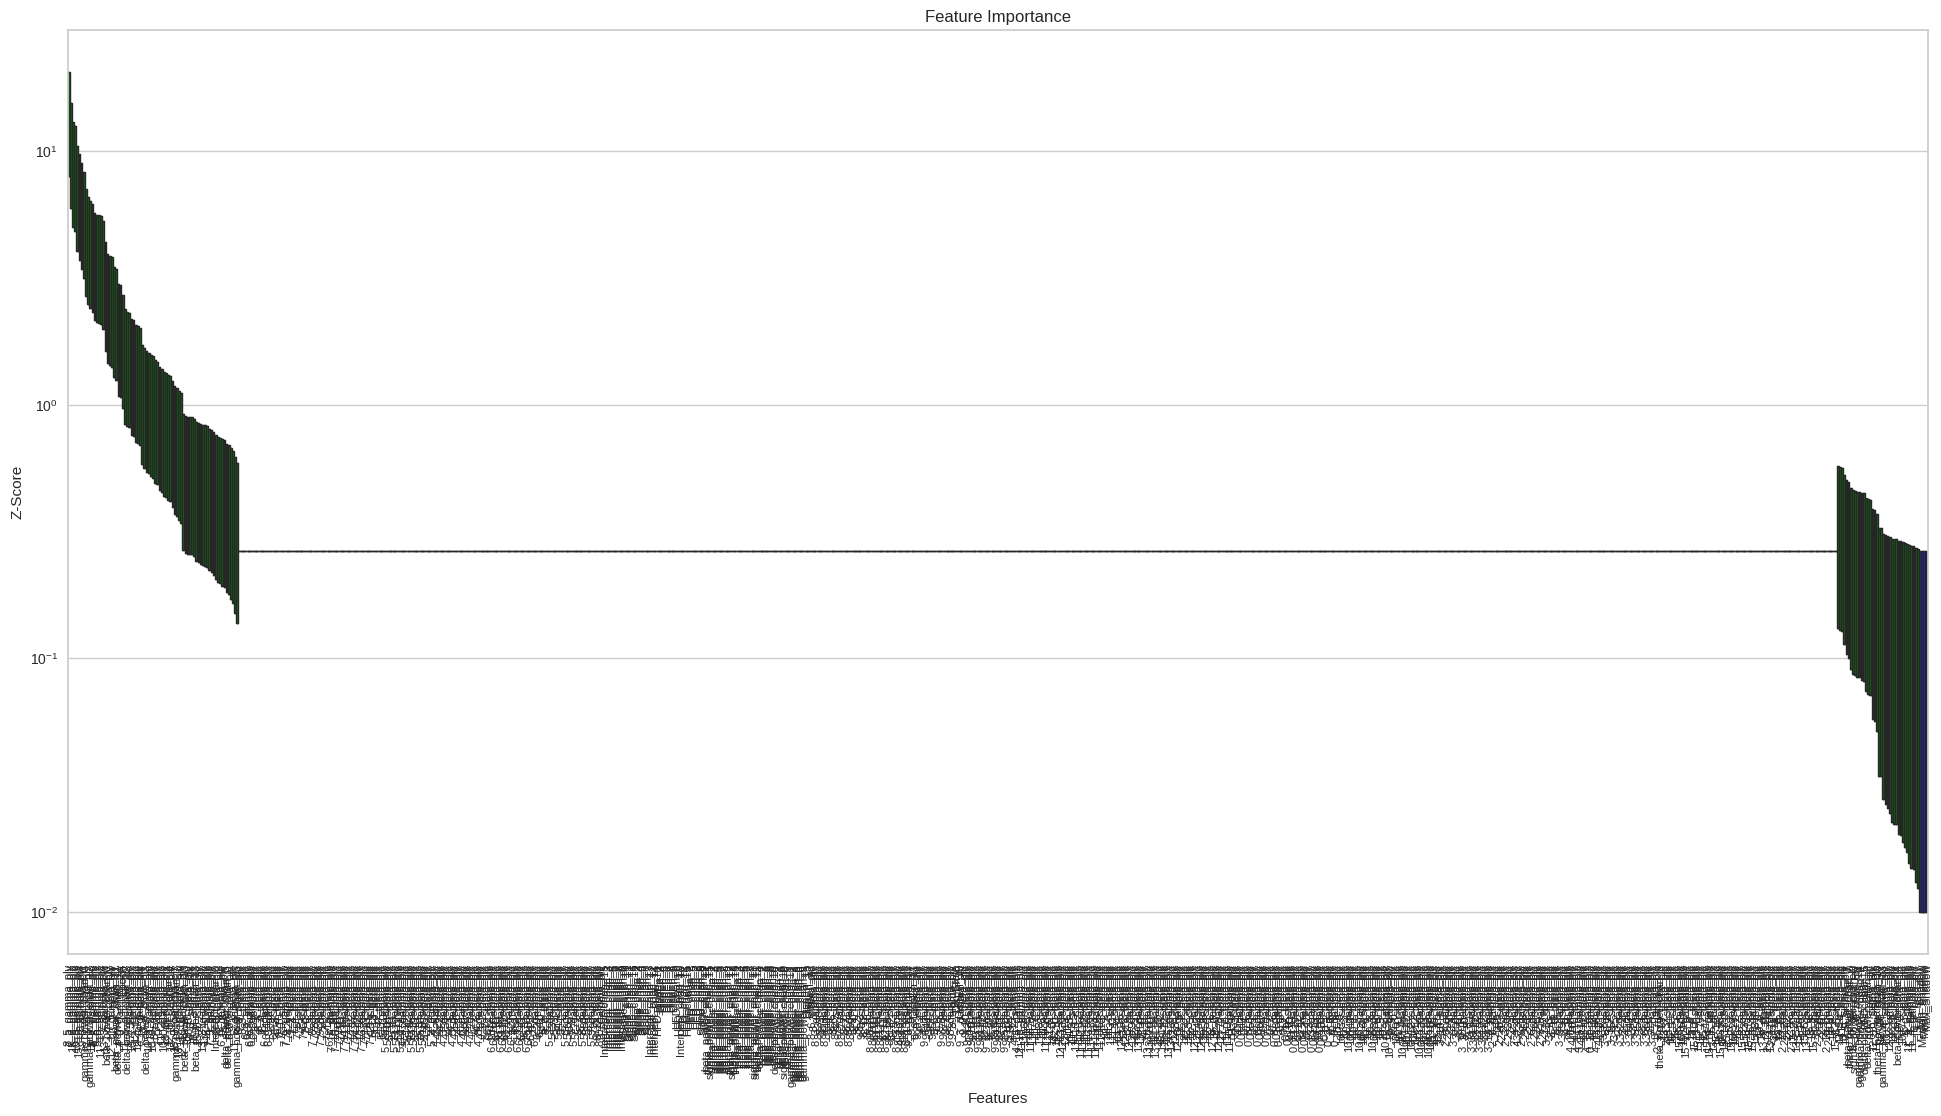

Selected features at fold 3 are: ['10_0_gamma_plv', '10_3_gamma_plv', '10_5_gamma_plv', '10_5_sigma_plv', '10_7_beta_plv', '10_7_gamma_plv', '10_7_sigma_plv', '10_9_gamma_plv', '10_9_sigma_plv', '11_10_beta_plv', '11_10_gamma_plv', '11_10_theta_plv', '11_2_gamma_plv', '11_2_sigma_plv', '11_3_gamma_plv', '11_4_beta_plv', '11_4_gamma_plv', '11_5_gamma_plv', '11_8_gamma_plv', '12_0_beta_plv', '12_0_gamma_plv', '12_10_beta_plv', '12_10_gamma_plv', '12_10_sigma_plv', '12_11_beta_plv', '12_11_gamma_plv', '12_11_sigma_plv', '12_11_theta_plv', '12_2_gamma_plv', '12_3_beta_plv', '12_3_gamma_plv', '12_6_sigma_plv', '13_11_sigma_plv', '13_12_gamma_plv', '13_2_beta_plv', '13_2_gamma_plv', '13_2_sigma_plv', '13_3_beta_plv', '13_3_gamma_plv', '13_3_theta_plv', '13_4_beta_plv', '13_4_sigma_plv', '13_8_beta_plv', '13_8_gamma_plv', '13_8_sigma_plv', '15_0_gamma_plv', '15_0_sigma_plv', '15_10_beta_plv', '15_10_gamma_plv', '15_12_beta_plv', '15_5_beta_plv', '15_5_gamma_plv', '15_7_beta_plv', '15_9_sigma_

In [61]:
params = dict([('colsample_bytree', 0.1),
               ('learning_rate', 0.347),
               ('max_depth', 2),
               ('n_estimators', 1_000),
               ('reg_alpha', 1e-09),
               ('reg_lambda', 100.0),
               ('subsample', 1.0)])

folds = 3
skf = StratifiedKFold(n_splits=folds)

selected_columns = list()
    
for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    
    print(f"FOLD {k+1}/{folds}")
    
   
    estimator_borutashap_rat=XGBClassifier(n_jobs = -1,random_state=42, max_depth = 4)
    Feature_Selector_rat = BorutaShap(model=estimator_borutashap_rat,
                                  importance_measure='shap', 
                                  classification=True)

    Feature_Selector_rat.fit(X=X_train.iloc[train_idx, :], y=y_train.iloc[train_idx], n_trials=50, random_state=0)
    
    Feature_Selector_rat.plot(which_features='all', figsize=(24,12))
    
    selected_columns.append(sorted(Feature_Selector_rat.Subset().columns))
    
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")

In [62]:
final_selection = sorted({item for selection in selected_columns for item in selection})
print(final_selection)

['10_0_beta_plv', '10_0_gamma_plv', '10_0_sigma_plv', '10_0_theta_plv', '10_2_beta_plv', '10_2_gamma_plv', '10_3_beta_plv', '10_3_gamma_plv', '10_3_sigma_plv', '10_4_gamma_plv', '10_5_beta_plv', '10_5_gamma_plv', '10_5_sigma_plv', '10_5_theta_plv', '10_6_gamma_plv', '10_7_beta_plv', '10_7_gamma_plv', '10_7_sigma_plv', '10_8_beta_plv', '10_8_gamma_plv', '10_8_sigma_plv', '10_8_theta_plv', '10_9_beta_plv', '10_9_gamma_plv', '10_9_sigma_plv', '11_0_gamma_plv', '11_10_beta_plv', '11_10_gamma_plv', '11_10_theta_plv', '11_2_beta_plv', '11_2_gamma_plv', '11_2_sigma_plv', '11_3_gamma_plv', '11_4_beta_plv', '11_4_gamma_plv', '11_5_gamma_plv', '11_6_gamma_plv', '11_7_beta_plv', '11_7_gamma_plv', '11_7_sigma_plv', '11_8_beta_plv', '11_8_gamma_plv', '11_8_sigma_plv', '11_9_gamma_plv', '12_0_beta_plv', '12_0_gamma_plv', '12_0_sigma_plv', '12_10_beta_plv', '12_10_gamma_plv', '12_10_sigma_plv', '12_11_beta_plv', '12_11_gamma_plv', '12_11_sigma_plv', '12_11_theta_plv', '12_2_beta_plv', '12_2_gamma_plv

## Human Data Feature Selection

In [19]:
os.chdir('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Scripts/Preprocessing/')
%run constants.py

all_features_human = pd.read_csv('/home/melissa/PROJECT_DIRECTORIES/EEGFeatureExtraction/Results/Human/all_patient_features.csv', index_col = 0)

In [20]:
all_features_human

,Genotype,Patient,Power_delta_0,Power_alpha_0,Power_beta_0,Power_gamma_0,Power_delta_1,Power_alpha_1,Power_beta_1,Power_gamma_1,...,F3_dispen,C3_dispen,O1_dispen,M2_dispen,hfd_chan_0,hfd_chan_1,hfd_chan_2,hfd_chan_3,hfd_chan_4,hfd_chan_5
0,0,1,2.021686e-40,1.414745e-41,5.473841e-42,6.244479e-41,2.021686e-40,1.414745e-41,5.473841e-42,6.244479e-41,...,1.377302,1.664450,1.637091,1.624979,1.281659,1.356857,1.443605,1.455377,1.400428,1.040776
1,0,1,9.234922e-41,5.348619e-41,1.123277e-41,4.368297e-42,9.234922e-41,5.348619e-41,1.123277e-41,4.368297e-42,...,1.974854,1.947366,2.074029,1.679804,1.245554,1.247783,1.307705,1.386245,1.347598,1.025445
2,0,1,1.578317e-40,1.585618e-41,8.581934e-42,6.873764e-41,1.578317e-40,1.585618e-41,8.581934e-42,6.873764e-41,...,2.186308,2.681092,2.213581,1.504507,1.218610,1.218719,1.443252,1.564114,1.434888,1.018065
3,0,1,1.360563e-40,3.267708e-41,5.297864e-42,9.640001e-41,1.360563e-40,3.267708e-41,5.297864e-42,9.640001e-41,...,1.587280,1.771192,1.692554,1.450994,1.295126,1.337063,1.339633,1.484725,1.412665,1.007476
4,0,1,3.358105e-40,1.533509e-41,8.564634e-42,1.352407e-41,3.358105e-40,1.533509e-41,8.564634e-42,1.352407e-41,...,1.671917,1.974867,1.823064,1.560174,1.237608,1.260508,1.347309,1.552783,1.421154,1.025981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,1,30,8.996472e-11,1.617301e-11,3.049208e-12,2.506163e-12,5.320294e-11,1.716340e-11,3.235346e-12,1.833784e-12,...,2.553581,2.647442,2.578583,2.058323,1.073465,1.074639,1.066013,1.148640,1.112540,1.140124
873,1,30,2.133108e-11,1.352994e-11,2.296948e-12,1.051443e-12,4.511572e-11,1.533833e-11,2.219716e-12,1.048053e-12,...,2.425061,2.264983,2.130058,2.279193,1.080244,1.080445,1.123070,1.194130,1.164164,1.158372
874,1,30,1.033695e-10,1.160544e-11,2.745708e-12,1.303825e-12,7.733722e-11,1.730516e-11,2.343207e-12,9.282719e-13,...,2.134380,2.362109,2.322673,2.428495,1.178738,1.176983,1.258695,1.322602,1.244002,1.156172
875,1,30,7.193265e-11,9.530360e-12,2.349388e-12,8.645043e-13,1.097380e-10,1.480513e-11,4.180056e-12,3.879497e-12,...,2.066033,2.130596,1.796899,2.542133,1.148823,1.151172,1.204850,1.256278,1.226778,1.163000


In [21]:
X = all_features_human.iloc[:, 1:].drop(['Patient'], axis = 1)
y = all_features_human.iloc[:, 0]
patient_ids = all_features_human['Patient']

In [22]:
# Initial train-test split by group
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=patient_ids))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_ids = np.unique(patient_ids.iloc[train_idx])
test_ids = np.unique(patient_ids.iloc[test_idx])

FOLD 1/3


  0%|          | 0/50 [00:00<?, ?it/s]

83 attributes confirmed important: ['Power_gamma_1', 'F3_dispen', 'hfd_chan_3', 'Slope_2', '3_1_beta_plv', 'Power_gamma_0', 'Power_gamma_2', '3_4_gamma', 'Power_alpha_0', '4_3_alpha_plv', '1_2_delta', 'E2_dispen', '0_2_delta', '0_4_gamma', '5_1_alpha_plv', 'Power_gamma_4', '3_0_alpha_plv', 'Power_delta_0', '3_2_delta_plv', '4_1_beta_plv', 'Power_delta_4', 'Power_beta_3', '0_3_gamma', '3_1_delta_plv', '4_0_alpha_plv', 'hfd_chan_1', '4_0_gamma_plv', '0_1_delta', '1_5_gamma', 'hfd_chan_5', 'Power_delta_2', '3_2_beta_plv', '2_3_gamma', '3_0_beta_plv', '0_5_gamma', '2_0_alpha_plv', 'Power_beta_2', 'Intercept_2', 'hfd_chan_4', 'Power_alpha_3', 'Power_beta_4', 'Power_beta_1', 'Power_alpha_2', '1_0_alpha_plv', '3_5_gamma', 'C3_dispen', '4_2_alpha_plv', 'Power_alpha_4', 'Slope_0', 'Power_delta_1', '0_4_alpha', '3_2_alpha_plv', '1_3_gamma', 'Power_alpha_1', 'Power_gamma_3', '3_4_delta', 'Intercept_3', 'O1_dispen', 'M2_dispen', '0_1_alpha', 'hfd_chan_0', '4_3_gamma_plv', 'hfd_chan_2', '2_0_gamma_

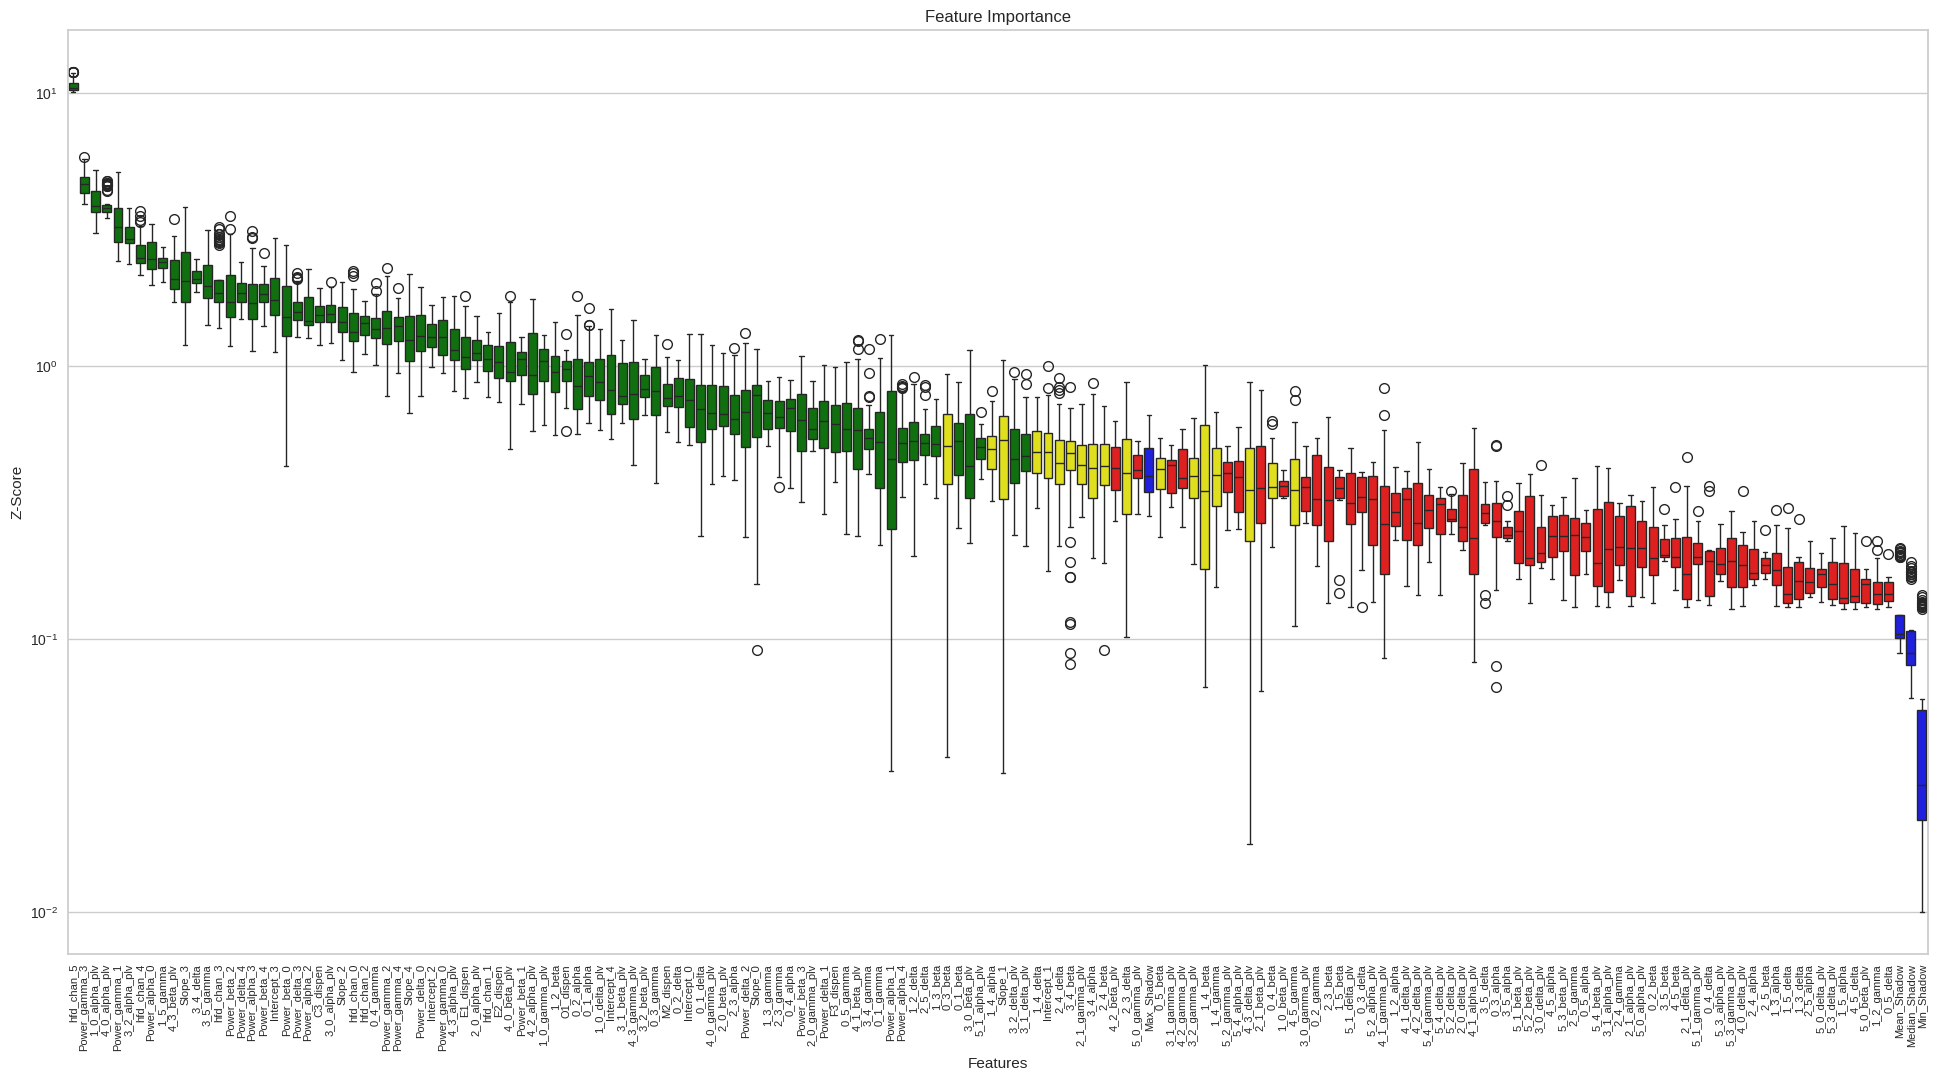

Selected features at fold 1 are: ['0_1_alpha', '0_1_beta', '0_1_delta', '0_1_gamma', '0_2_alpha', '0_2_delta', '0_3_gamma', '0_4_alpha', '0_4_gamma', '0_5_gamma', '1_0_alpha_plv', '1_0_delta_plv', '1_0_gamma_plv', '1_2_beta', '1_2_delta', '1_3_beta', '1_3_gamma', '1_5_gamma', '2_0_alpha_plv', '2_0_beta_plv', '2_0_gamma_plv', '2_3_alpha', '2_3_gamma', '2_5_delta', '3_0_alpha_plv', '3_0_beta_plv', '3_1_beta_plv', '3_1_delta_plv', '3_2_alpha_plv', '3_2_beta_plv', '3_2_delta_plv', '3_4_delta', '3_4_gamma', '3_5_gamma', '4_0_alpha_plv', '4_0_beta_plv', '4_0_gamma_plv', '4_1_beta_plv', '4_2_alpha_plv', '4_3_alpha_plv', '4_3_beta_plv', '4_3_gamma_plv', '5_1_alpha_plv', 'C3_dispen', 'E1_dispen', 'E2_dispen', 'F3_dispen', 'Intercept_0', 'Intercept_2', 'Intercept_3', 'Intercept_4', 'M2_dispen', 'O1_dispen', 'Power_alpha_0', 'Power_alpha_1', 'Power_alpha_2', 'Power_alpha_3', 'Power_alpha_4', 'Power_beta_0', 'Power_beta_1', 'Power_beta_2', 'Power_beta_3', 'Power_beta_4', 'Power_delta_0', 'Power_de

  0%|          | 0/50 [00:00<?, ?it/s]

87 attributes confirmed important: ['Power_gamma_1', 'F3_dispen', 'hfd_chan_3', 'Slope_2', 'Slope_1', '3_1_beta_plv', 'Power_gamma_0', 'Power_gamma_2', '3_4_gamma', 'Power_alpha_0', '4_3_alpha_plv', '1_2_delta', '1_2_alpha', 'E2_dispen', '0_2_delta', '5_1_alpha_plv', 'Power_gamma_4', '3_2_delta_plv', '3_2_gamma_plv', '0_4_delta', 'Power_delta_4', 'Power_beta_3', '0_3_gamma', '4_0_alpha_plv', 'hfd_chan_1', '4_0_gamma_plv', '0_1_delta', '1_5_gamma', 'hfd_chan_5', '3_2_beta_plv', '2_3_gamma', '3_0_beta_plv', '4_2_beta_plv', '2_0_alpha_plv', 'Power_beta_2', 'Intercept_2', '3_4_beta', 'hfd_chan_4', 'Power_alpha_3', 'Power_beta_4', 'Power_beta_1', 'Power_alpha_2', '1_0_alpha_plv', '3_5_gamma', 'C3_dispen', '4_2_alpha_plv', 'Slope_0', 'Intercept_1', '4_3_delta_plv', 'Power_delta_1', '0_4_alpha', '3_2_alpha_plv', '4_2_gamma_plv', '1_4_delta', '0_4_beta', '2_3_delta', '1_4_gamma', 'Power_gamma_3', '3_4_delta', 'Intercept_3', 'M2_dispen', '0_1_alpha', 'hfd_chan_0', '3_1_alpha_plv', '4_3_gamma_pl

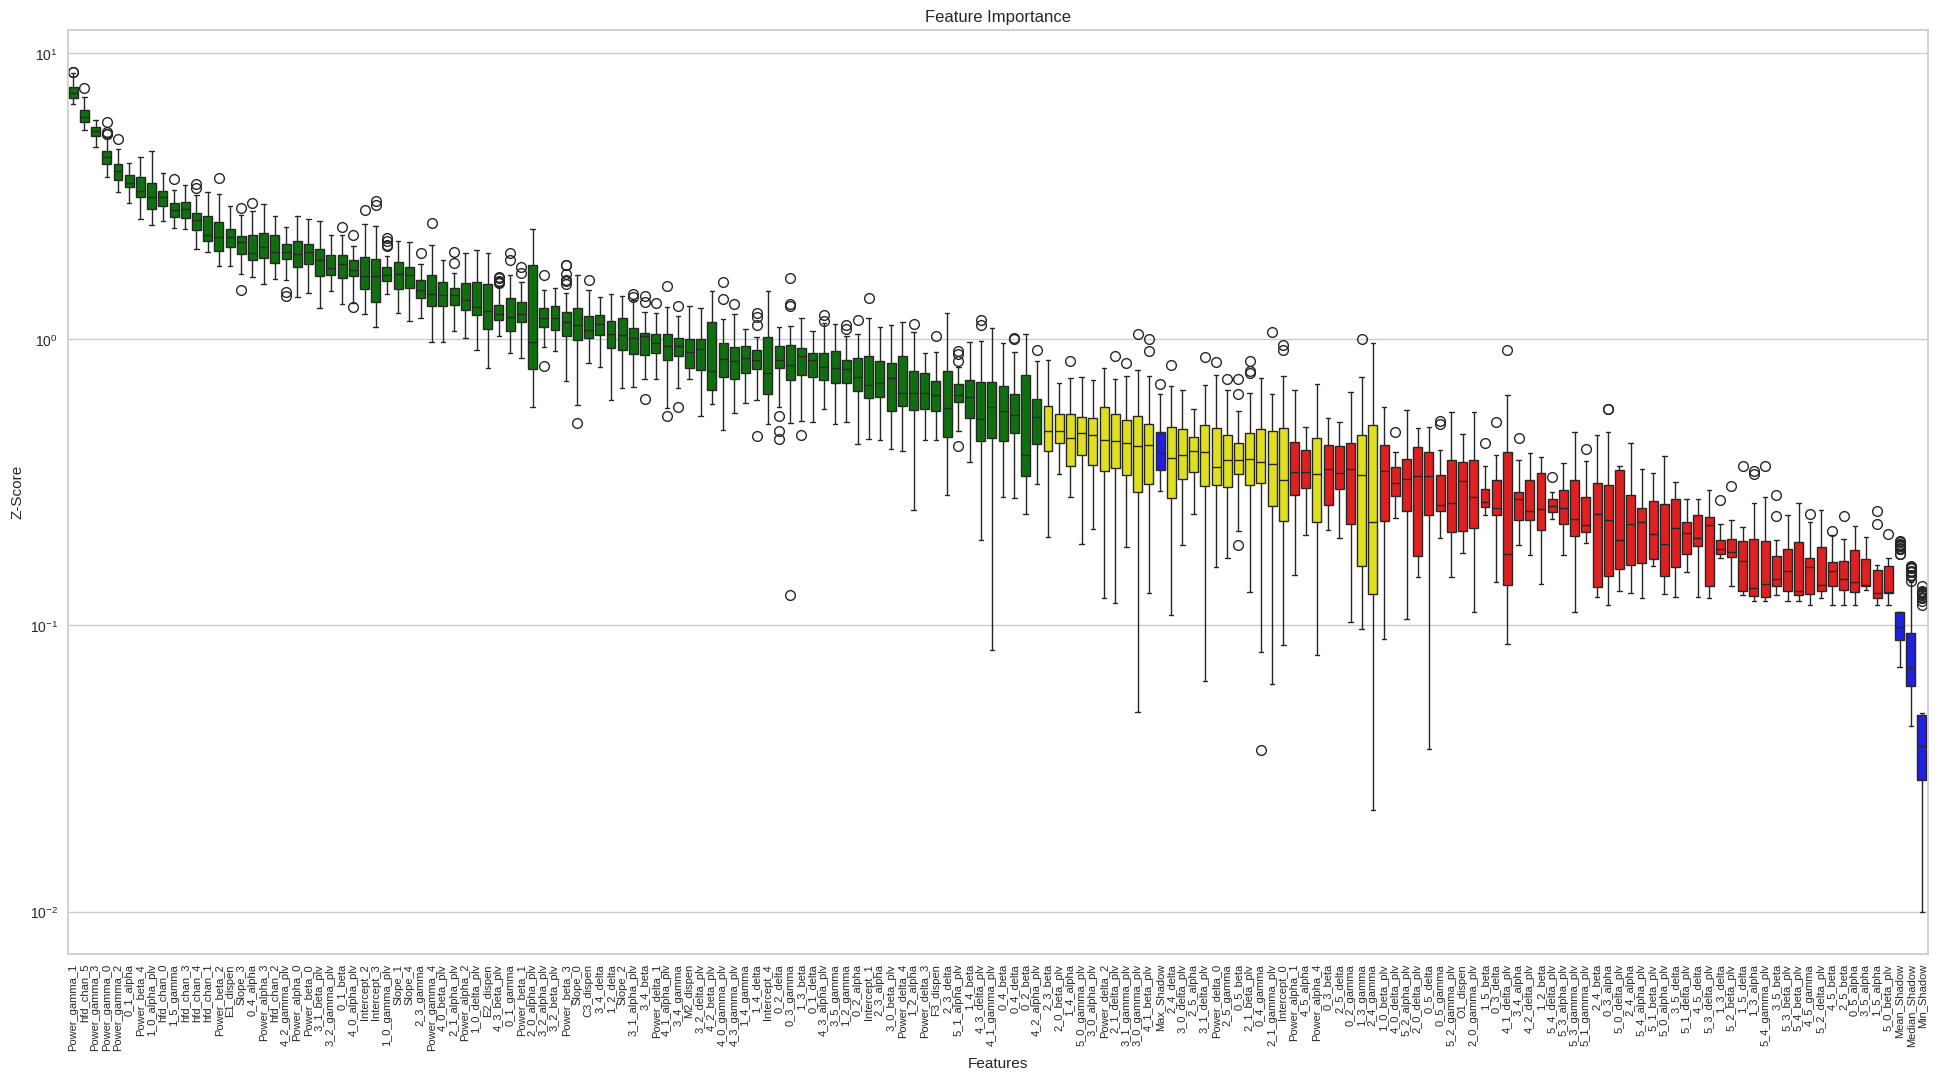

Selected features at fold 2 are: ['0_1_alpha', '0_1_beta', '0_1_delta', '0_1_gamma', '0_2_alpha', '0_2_beta', '0_2_delta', '0_3_gamma', '0_4_alpha', '0_4_beta', '0_4_delta', '1_0_alpha_plv', '1_0_delta_plv', '1_0_gamma_plv', '1_2_alpha', '1_2_delta', '1_2_gamma', '1_3_beta', '1_4_beta', '1_4_delta', '1_4_gamma', '1_5_gamma', '2_0_alpha_plv', '2_1_alpha_plv', '2_3_alpha', '2_3_delta', '2_3_gamma', '3_0_beta_plv', '3_1_alpha_plv', '3_1_beta_plv', '3_2_alpha_plv', '3_2_beta_plv', '3_2_delta_plv', '3_2_gamma_plv', '3_4_beta', '3_4_delta', '3_4_gamma', '3_5_gamma', '4_0_alpha_plv', '4_0_beta_plv', '4_0_gamma_plv', '4_1_alpha_plv', '4_1_gamma_plv', '4_2_alpha_plv', '4_2_beta_plv', '4_2_gamma_plv', '4_3_alpha_plv', '4_3_beta_plv', '4_3_delta_plv', '4_3_gamma_plv', '5_1_alpha_plv', 'C3_dispen', 'E1_dispen', 'E2_dispen', 'F3_dispen', 'Intercept_1', 'Intercept_2', 'Intercept_3', 'Intercept_4', 'M2_dispen', 'Power_alpha_0', 'Power_alpha_2', 'Power_alpha_3', 'Power_beta_0', 'Power_beta_1', 'Power_

  0%|          | 0/50 [00:00<?, ?it/s]

70 attributes confirmed important: ['Power_delta_4', 'Power_beta_3', 'Power_gamma_1', 'C3_dispen', 'Intercept_4', '1_4_beta', '3_1_delta_plv', '4_0_alpha_plv', '4_2_alpha_plv', '4_0_beta_plv', '3_0_gamma_plv', '2_1_alpha_plv', '4_3_beta_plv', 'hfd_chan_3', 'Slope_0', 'Intercept_1', '4_0_gamma_plv', 'Slope_2', '0_1_delta', 'Slope_1', '0_3_beta', '2_1_gamma_plv', 'Power_gamma_0', 'Power_gamma_2', '0_1_gamma', '1_5_gamma', 'hfd_chan_5', '1_0_gamma_plv', 'Power_delta_1', '3_2_alpha_plv', '3_4_alpha', 'Power_delta_2', '3_2_beta_plv', 'Power_beta_0', 'Power_alpha_0', '2_4_delta', 'Slope_3', '2_0_delta_plv', '0_5_gamma', '2_3_beta', '1_2_alpha', '2_0_alpha_plv', 'Power_beta_2', 'Power_alpha_1', 'E2_dispen', '1_4_delta', '0_4_beta', '0_2_delta', '0_4_gamma', '2_4_gamma', 'Intercept_2', 'Power_gamma_4', 'Power_gamma_3', 'Power_delta_0', 'Slope_4', 'Intercept_0', '3_4_beta', 'O1_dispen', 'M2_dispen', 'hfd_chan_4', '1_0_delta_plv', 'hfd_chan_0', '2_0_beta_plv', '3_1_alpha_plv', 'Power_beta_4', 'P

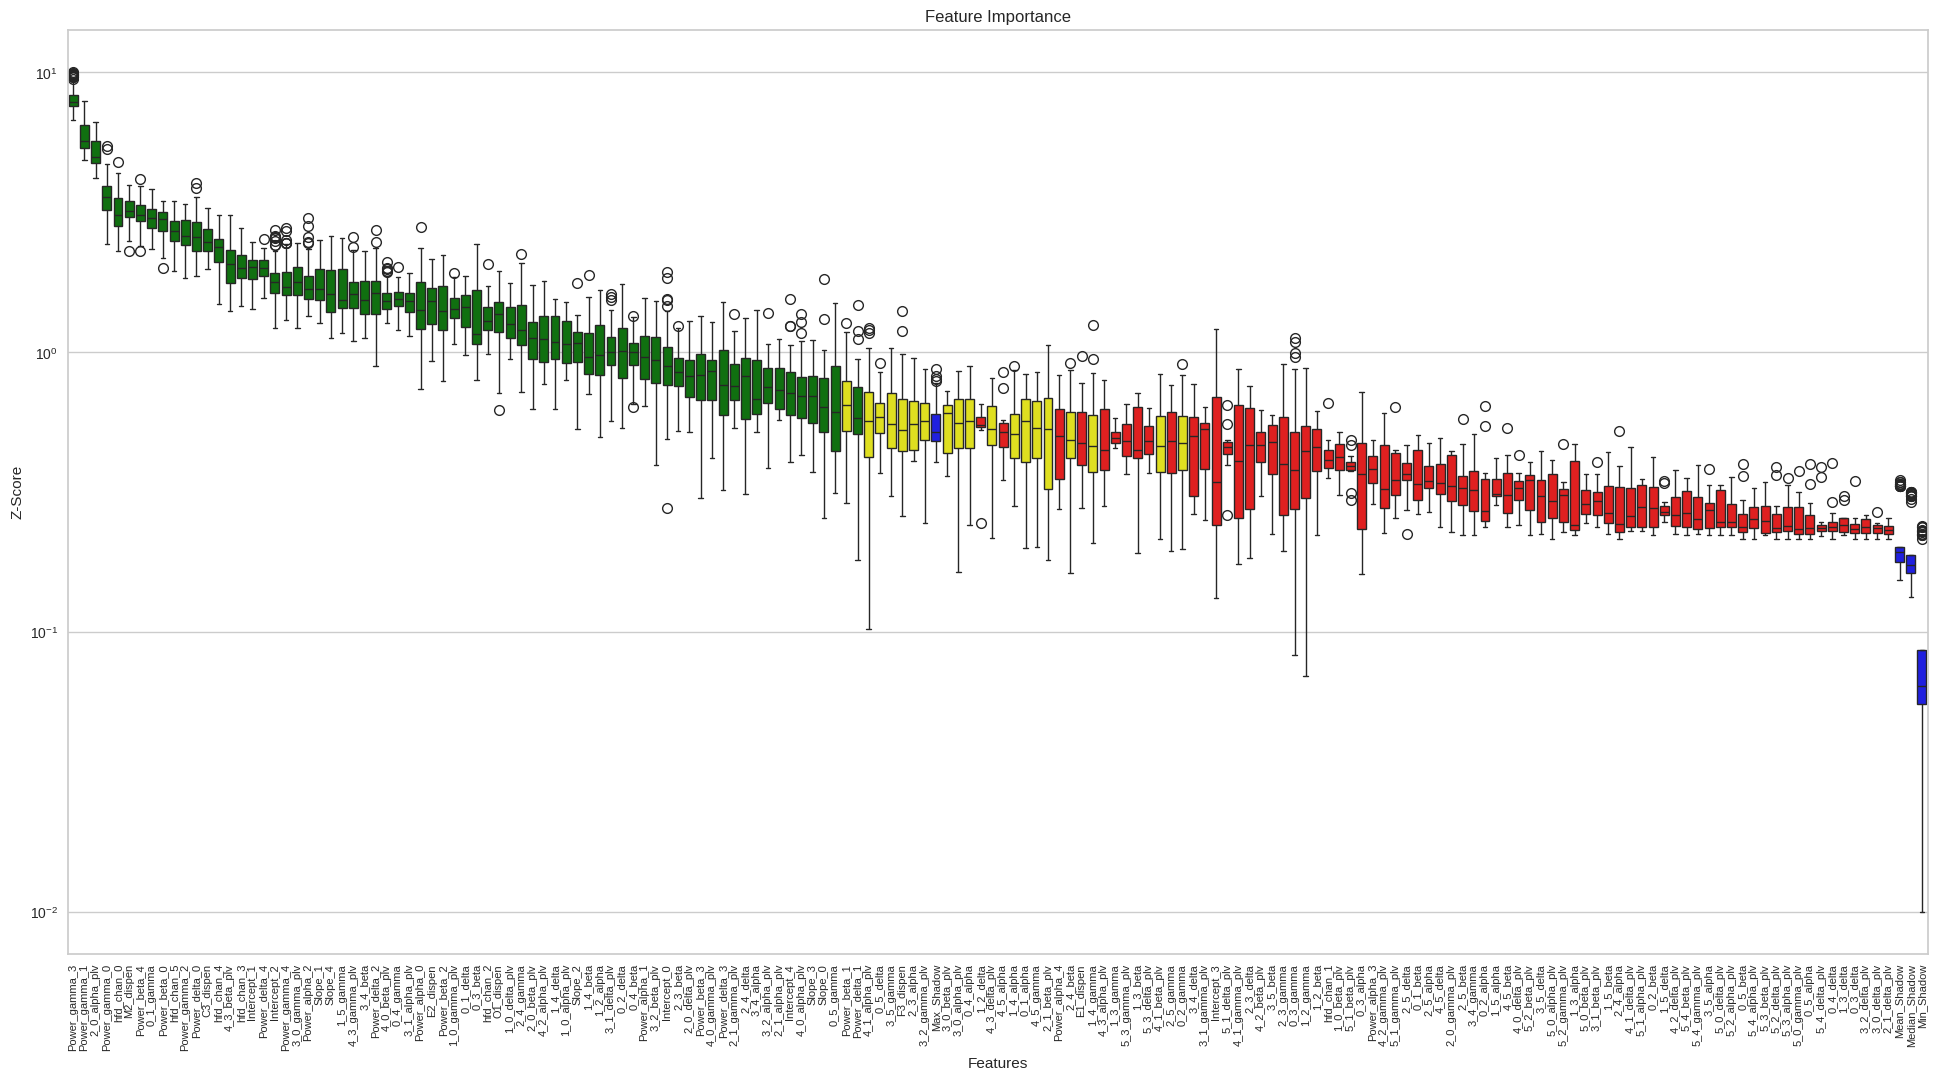

Selected features at fold 3 are: ['0_1_delta', '0_1_gamma', '0_2_delta', '0_3_beta', '0_4_beta', '0_4_gamma', '0_5_gamma', '1_0_alpha_plv', '1_0_delta_plv', '1_0_gamma_plv', '1_2_alpha', '1_4_beta', '1_4_delta', '1_5_gamma', '2_0_alpha_plv', '2_0_beta_plv', '2_0_delta_plv', '2_1_alpha_plv', '2_1_gamma_plv', '2_3_beta', '2_4_delta', '2_4_gamma', '3_0_gamma_plv', '3_1_alpha_plv', '3_1_delta_plv', '3_2_alpha_plv', '3_2_beta_plv', '3_4_alpha', '3_4_beta', '4_0_alpha_plv', '4_0_beta_plv', '4_0_gamma_plv', '4_2_alpha_plv', '4_3_beta_plv', '4_3_gamma_plv', 'C3_dispen', 'E2_dispen', 'Intercept_0', 'Intercept_1', 'Intercept_2', 'Intercept_4', 'M2_dispen', 'O1_dispen', 'Power_alpha_0', 'Power_alpha_1', 'Power_alpha_2', 'Power_beta_0', 'Power_beta_2', 'Power_beta_3', 'Power_beta_4', 'Power_delta_0', 'Power_delta_1', 'Power_delta_2', 'Power_delta_3', 'Power_delta_4', 'Power_gamma_0', 'Power_gamma_1', 'Power_gamma_2', 'Power_gamma_3', 'Power_gamma_4', 'Slope_0', 'Slope_1', 'Slope_2', 'Slope_3', 'Sl

In [51]:
params = dict([('colsample_bytree', 0.1),
               ('learning_rate', 0.347),
               ('max_depth', 2),
               ('n_estimators', 1_000),
               ('reg_alpha', 1e-09),
               ('reg_lambda', 100.0),
               ('subsample', 1.0)])

folds = 3
skf = StratifiedKFold(n_splits=folds)

selected_columns = list()
    
for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    
    print(f"FOLD {k+1}/{folds}")
    
   
    estimator_borutashap=XGBClassifier(n_jobs = -1,random_state=42, max_depth = 4)
    Feature_Selector = BorutaShap(model=estimator_borutashap,
                                  importance_measure='shap', 
                                  classification=True)

    Feature_Selector.fit(X=X_train.iloc[train_idx, :], y=y_train.iloc[train_idx], n_trials=50, random_state=0)
    
    Feature_Selector.plot(which_features='all', figsize=(24,12))
    
    selected_columns.append(sorted(Feature_Selector.Subset().columns))
    
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")

In [52]:
final_selection = sorted({item for selection in selected_columns for item in selection})
print(final_selection)

['0_1_alpha', '0_1_beta', '0_1_delta', '0_1_gamma', '0_2_alpha', '0_2_beta', '0_2_delta', '0_3_beta', '0_3_gamma', '0_4_alpha', '0_4_beta', '0_4_delta', '0_4_gamma', '0_5_gamma', '1_0_alpha_plv', '1_0_delta_plv', '1_0_gamma_plv', '1_2_alpha', '1_2_beta', '1_2_delta', '1_2_gamma', '1_3_beta', '1_3_gamma', '1_4_beta', '1_4_delta', '1_4_gamma', '1_5_gamma', '2_0_alpha_plv', '2_0_beta_plv', '2_0_delta_plv', '2_0_gamma_plv', '2_1_alpha_plv', '2_1_gamma_plv', '2_3_alpha', '2_3_beta', '2_3_delta', '2_3_gamma', '2_4_delta', '2_4_gamma', '2_5_delta', '3_0_alpha_plv', '3_0_beta_plv', '3_0_gamma_plv', '3_1_alpha_plv', '3_1_beta_plv', '3_1_delta_plv', '3_2_alpha_plv', '3_2_beta_plv', '3_2_delta_plv', '3_2_gamma_plv', '3_4_alpha', '3_4_beta', '3_4_delta', '3_4_gamma', '3_5_gamma', '4_0_alpha_plv', '4_0_beta_plv', '4_0_gamma_plv', '4_1_alpha_plv', '4_1_beta_plv', '4_1_gamma_plv', '4_2_alpha_plv', '4_2_beta_plv', '4_2_gamma_plv', '4_3_alpha_plv', '4_3_beta_plv', '4_3_delta_plv', '4_3_gamma_plv', '5_1